# Denoiser - LOL Dataset

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [24]:
import cv2
print(cv2.__version__)

4.5.5


In [25]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [26]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [27]:
import os
for dirname, _, filenames in os.walk('LOLdataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

LOLdataset/eval15/.DS_Store
LOLdataset/eval15/low/669.png
LOLdataset/eval15/low/146.png
LOLdataset/eval15/low/1.png
LOLdataset/eval15/low/665.png
LOLdataset/eval15/low/22.png
LOLdataset/eval15/low/547.png
LOLdataset/eval15/low/79.png
LOLdataset/eval15/low/23.png
LOLdataset/eval15/low/179.png
LOLdataset/eval15/low/55.png
LOLdataset/eval15/low/748.png
LOLdataset/eval15/low/778.png
LOLdataset/eval15/low/493.png
LOLdataset/eval15/low/111.png
LOLdataset/eval15/low/780.png
LOLdataset/eval15/high/669.png
LOLdataset/eval15/high/146.png
LOLdataset/eval15/high/1.png
LOLdataset/eval15/high/665.png
LOLdataset/eval15/high/22.png
LOLdataset/eval15/high/547.png
LOLdataset/eval15/high/79.png
LOLdataset/eval15/high/23.png
LOLdataset/eval15/high/179.png
LOLdataset/eval15/high/55.png
LOLdataset/eval15/high/748.png
LOLdataset/eval15/high/778.png
LOLdataset/eval15/high/493.png
LOLdataset/eval15/high/111.png
LOLdataset/eval15/high/780.png
LOLdataset/__MACOSX/._eval15
LOLdataset/__MACOSX/._our485
LOLdataset/

In [28]:
# path to zipped & working directories
#path_zip = 'LOLdataset/dataset/'
path = 'LOLdataset/dataset/'

In [29]:
# unzip files first to working directory
# We could use also unzipped data source, but why not to learn something new?

# with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
#     zip_ref.extractall(path)

# with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
#     zip_ref.extractall(path)  
    
# with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
#     zip_ref.extractall(path)  
    
# with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
#     zip_ref.extractall(path)  

In [30]:
# store image names in list for later use
train_img = sorted(os.listdir(path + '/train'))
train_enhanced_img = sorted(os.listdir(path + '/train_enhanced'))
test_img = sorted(os.listdir(path + '/test'))

# Data preparation

In [31]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 3))
#    img = img[:, :, 0]
    
    return img

In [32]:
# preprocess i#mages
train = []
train_enhanced = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_enhanced/')):
    train_enhanced.append(process_image(path + 'train_enhanced/' + f))
    
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

# Exploratory data analysis

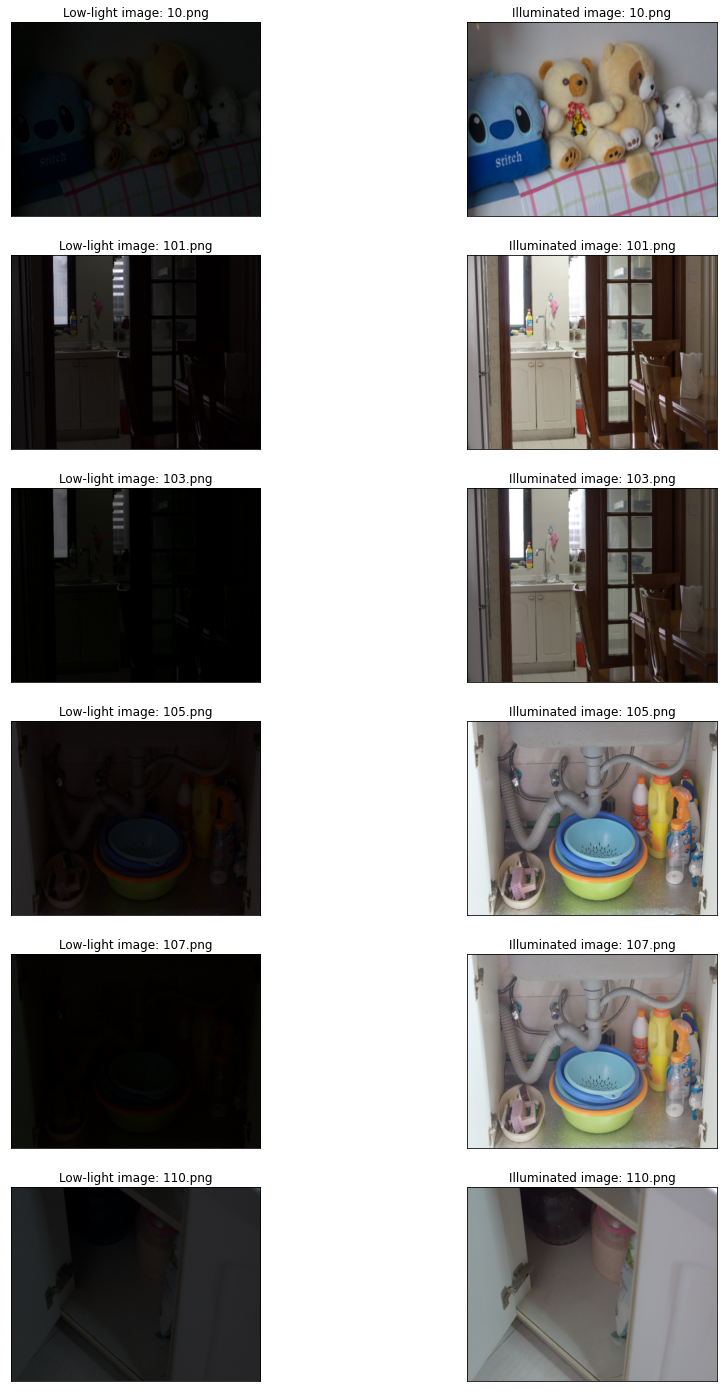

In [33]:
plt.figure(figsize=(15,25))

# "for i in range(x, y, step)" range from x until y, including x but not including y, 
# in steps of step value, and iterate for each of the element in this range using for loop
for i in range(0,12,2): 
    plt.subplot(6,2,i+1) # 6 is # of rows; 2 is # of columns, i+1 is position index
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,[2,1,0]])
    plt.title('Low-light image: {}'.format(train_img[i]))
    
    plt.subplot(6,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_enhanced[i][:,:,[2,1,0]])
    plt.title('Illuminated image: {}'.format(train_img[i]))

plt.show()

# Split data

In [34]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_enhanced)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

# Modeling

In [35]:
def model():
    input_layer = Input(shape=(420, 540, 3))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


In [15]:
model = model()

2022-04-08 13:27:57.613485: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-08 13:27:57.812277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 13:27:57.812481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 13:27:57.812647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0     

# Train model

In [17]:
callback = EarlyStopping(monitor='loss', patience=30)

In [18]:
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=100, batch_size=24, verbose=1, callbacks=[callback])

Epoch 1/100


2022-04-08 13:28:09.431424: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-04-08 13:28:09.950732: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


15/15 [==============================] - 19s 882ms/step - loss: 0.0388 - mae: 0.1514 - val_loss: 0.0441 - val_mae: 0.1710
Epoch 2/100
15/15 [==============================] - 10s 640ms/step - loss: 0.0256 - mae: 0.1275 - val_loss: 0.0439 - val_mae: 0.1710
Epoch 3/100
15/15 [==============================] - 10s 644ms/step - loss: 0.0246 - mae: 0.1247 - val_loss: 0.0431 - val_mae: 0.1699
Epoch 4/100
15/15 [==============================] - 10s 645ms/step - loss: 0.0246 - mae: 0.1244 - val_loss: 0.0431 - val_mae: 0.1696
Epoch 5/100
15/15 [==============================] - 10s 647ms/step - loss: 0.0240 - mae: 0.1226 - val_loss: 0.0431 - val_mae: 0.1692
Epoch 6/100
15/15 [==============================] - 10s 648ms/step - loss: 0.0233 - mae: 0.1211 - val_loss: 0.0437 - val_mae: 0.1702
Epoch 7/100
15/15 [==============================] - 10s 647ms/step - loss: 0.0225 - mae: 0.1185 - val_loss: 0.0429 - val_mae: 0.1690
Epoch 8/100
15/15 [==============================] - 10s 647ms/step - loss

Epoch 62/100
15/15 [==============================] - 10s 665ms/step - loss: 0.0207 - mae: 0.1144 - val_loss: 0.0299 - val_mae: 0.1391
Epoch 63/100
15/15 [==============================] - 10s 662ms/step - loss: 0.0211 - mae: 0.1150 - val_loss: 0.0245 - val_mae: 0.1250
Epoch 64/100
15/15 [==============================] - 10s 663ms/step - loss: 0.0205 - mae: 0.1131 - val_loss: 0.0243 - val_mae: 0.1262
Epoch 65/100
15/15 [==============================] - 10s 663ms/step - loss: 0.0204 - mae: 0.1130 - val_loss: 0.0255 - val_mae: 0.1249
Epoch 66/100
15/15 [==============================] - 10s 663ms/step - loss: 0.0222 - mae: 0.1171 - val_loss: 0.0264 - val_mae: 0.1279
Epoch 67/100
15/15 [==============================] - 10s 663ms/step - loss: 0.0214 - mae: 0.1155 - val_loss: 0.0254 - val_mae: 0.1292
Epoch 68/100
15/15 [==============================] - 10s 663ms/step - loss: 0.0217 - mae: 0.1160 - val_loss: 0.0287 - val_mae: 0.1356
Epoch 69/100
15/15 [==============================] - 1

# Plot error evolution on epochs

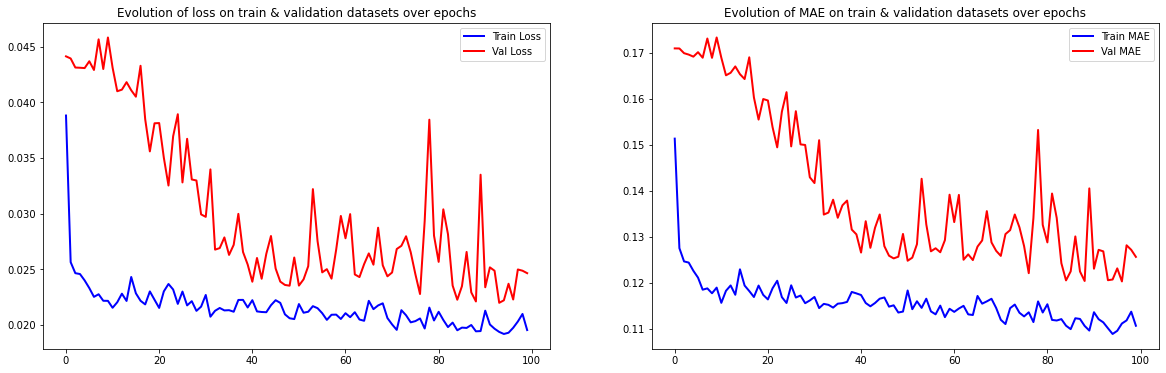

In [19]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [21]:
model.save('modelo1_color.h5')

# Evaluation

In [36]:
model = tf.keras.models.load_model('modelo1_color.h5')

2022-04-25 19:33:48.179388: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 19:33:48.308983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 19:33:48.309199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 19:33:48.309365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [37]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=16)

2022-04-25 19:33:56.440505: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-04-25 19:33:56.963851: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


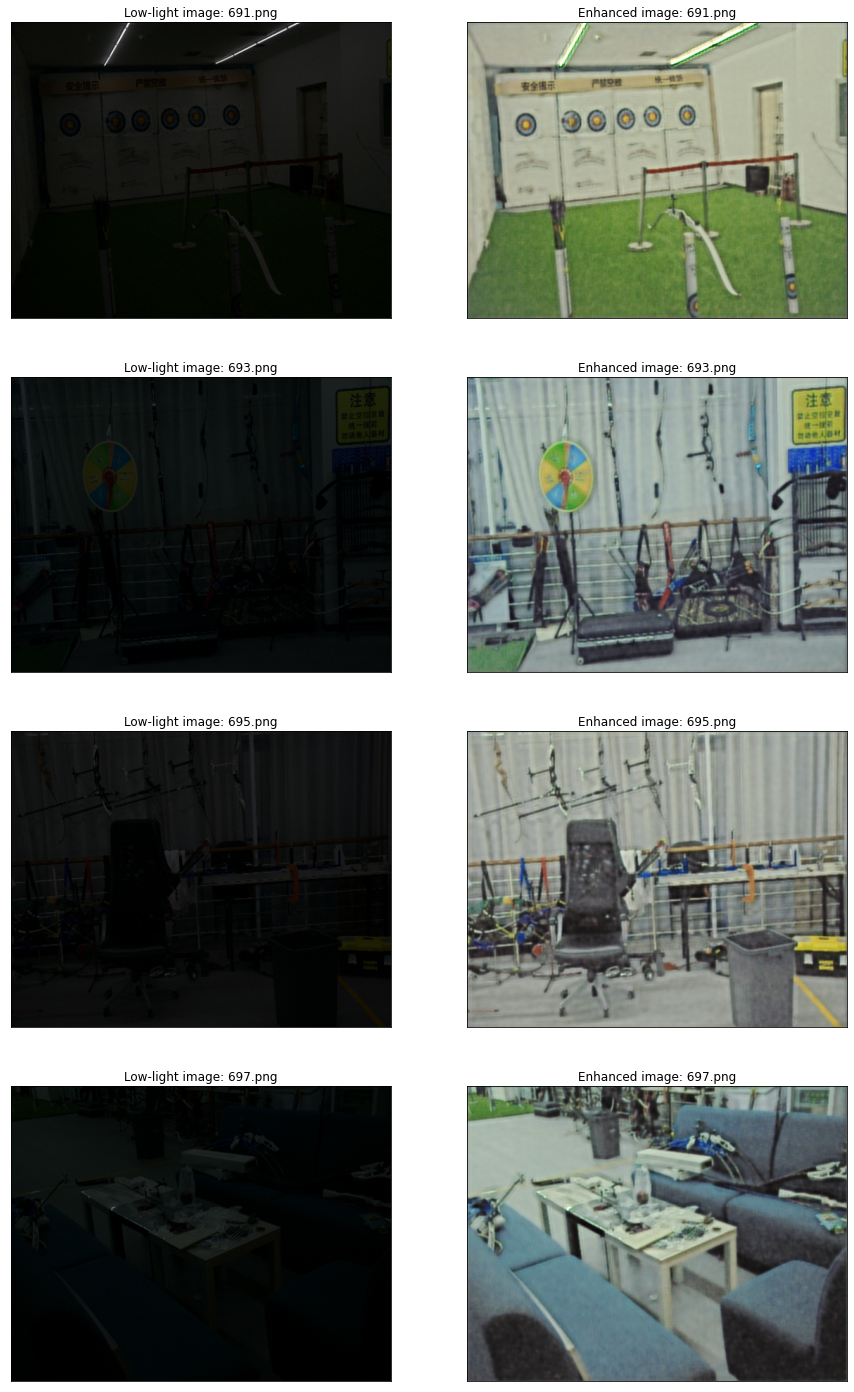

In [56]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,[2,1,0]])
    plt.title('Low-light image: {}'.format(test_img[i]))
    plt.imsave('enhanced_images/color_model/LowLight_image' + str(i) + '.png', X_test[i])
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,[2,1,0]])  
    plt.title('Enhanced image: {}'.format(test_img[i]))
    plt.imsave('enhanced_images/color_model/Enhanced_image' + str(i) + '.png', Y_test[i])

plt.show()

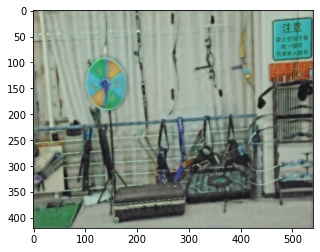

In [54]:
plt.imshow(Y_test[1])
plt.imsave('test.jpg',Y_test[1])

In [51]:
plt.savefig("testimage.png")

<Figure size 432x288 with 0 Axes>